## CIR Model to simulate changes in Interest Rate and Liability Hedging
The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasiceck model to prevent negative interest rates:

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt {r_{t}}}\,dW_{t} $$

## 

In [1]:
import numpy as np
import pandas as pd
import AKCRiskKit as ark
import ipywidgets as widgets
%load_ext autoreload
%autoreload 2

In [2]:
def inst_to_ann(r):
    """
    Converts a short rate to an annualized rate
    """
    return np.expm1(r)
    
def ann_to_inst(r):
    """
    Converts annualized to a short rate
    """
    return np.log1p(r)
    

## Generating the random price evolution of a Zero-Coupon Bond

The model can also be used to generate the movement of bond prices for a zero coupon bond that are implied by the generated interest rate, using the following equations:

$$P(t,T)=A(t,T)e^{-B(t,T)r_{t}}\!$$

where

$$ A(t,T)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} $$
and
$$ B(t,T)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} $$
and
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} $$
and
$$ \tau = T-t $$


In [3]:
import math
def cir(n_years=10, n_scenarios=1,a=0.05,b=0.03,sigma=0.05,steps_per_year=12,r_0=None):
    """
    Implements the CIR model
    """
    if r_0 is None: r_0 = b
    r_0=ann_to_inst(r_0)
    dt = 1/steps_per_year
    
    num_steps = int(n_years*steps_per_year) + 1
    shock = np.random.normal(0,scale=np.sqrt(dt),size=(num_steps,n_scenarios))
    
    rates = np.empty_like(shock)
    rates[0] = r_0
    
    ## for Price Generation
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ###
    
    def price(ttm,r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years,r_0)
    
    
    for step in range(1,num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        prices[step] = price(n_years-step*dt,rates[step])
    rates = pd.DataFrame(data=inst_to_ann(rates),index=range(num_steps))
    prices = pd.DataFrame(data=prices,index=range(num_steps))
    return rates, prices

In [4]:
def show_cir_prices(r_0=0.03, a=0.5, b=0.03, sigma=0.05, n_scenarios=5):
    cir(r_0=r_0, a=a, b=b, sigma=sigma, n_scenarios=n_scenarios)[1].plot(legend=False, figsize=(12,5))

controls = widgets.interactive(show_cir_prices,
                              r_0 = (0, .15, .01),
                              a = (0, 1, .1),
                               b = (0, .15, .01),
                               sigma= (0, .1, .01),
                               n_scenarios = (1, 100))
display(controls)

interactive(children=(FloatSlider(value=0.03, description='r_0', max=0.15, step=0.01), FloatSlider(value=0.5, …

In [13]:
a_0 = 0.75
rates, bond_prices = cir(r_0=0.03,n_years=10,b=0.03,n_scenarios=10)
liabilities = bond_prices
zc_10 = pd.Series(data=[1],index=[10])
zc_0 = ark.pv(zc_10 , r=0.03)
n_bonds = float(a_0/zc_0)
av_zc_bonds = n_bonds*bond_prices
av_cash =  a_0*(rates/12+1).cumprod()



<AxesSubplot:>

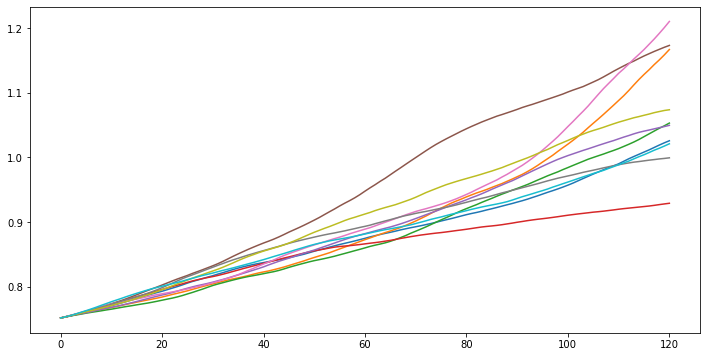

In [14]:
av_cash.plot(legend=False,figsize=(12,6))

<AxesSubplot:>

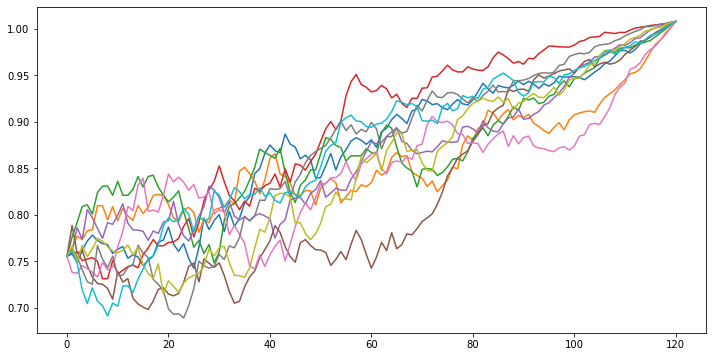

In [15]:
av_zc_bonds.plot(legend=False,figsize=(12,6))

<AxesSubplot:title={'center':'Return of funding ratio with Cash (10 scenarios)'}>

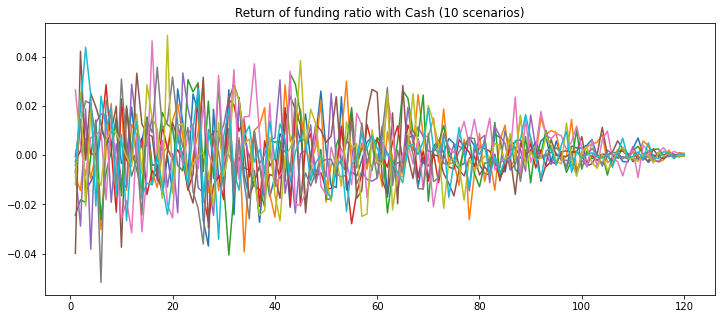

In [16]:
(av_cash/liabilities).pct_change().plot(title='Return of funding ratio with Cash (10 scenarios)',legend=False,figsize=(12,5))

<AxesSubplot:title={'center':'Return of funding ratio with Cash (10 scenarios)'}>

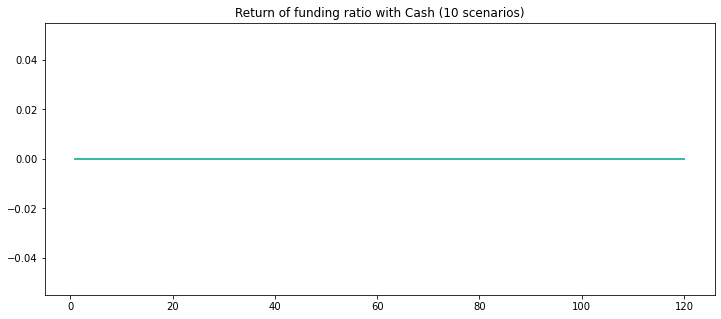

In [17]:
(av_zc_bonds/liabilities).pct_change().plot(title='Return of funding ratio with Cash (10 scenarios)',legend=False,figsize=(12,5))

In [19]:
a_0 = 0.5
rates, bond_prices = cir(r_0=0.03,n_years=10,b=0.03,n_scenarios=10000)
liabilities = bond_prices
zc_0 = ark.pv(zc_10 , r=0.03)
n_bonds=float(a_0/zc_0)
av_zc_bonds = n_bonds*bond_prices
av_cash =  a_0*(rates/12+1).cumprod()

<AxesSubplot:label='f113bf2d-3aca-453d-b510-7a4457c32c13'>

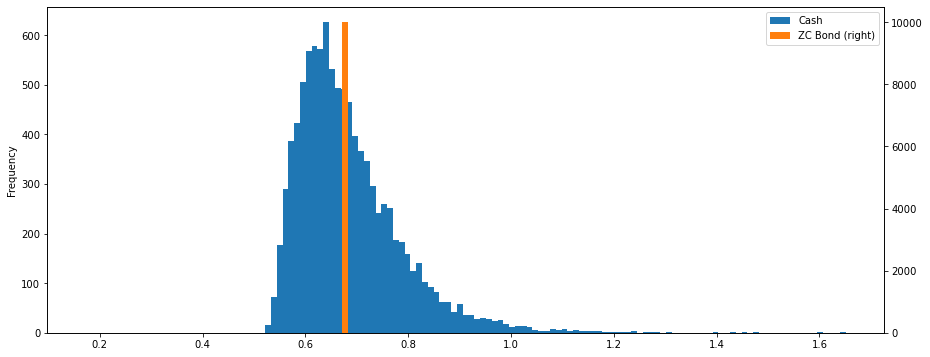

In [20]:
tfr_cash=av_cash.iloc[-1]/liabilities.iloc[-1]
tfr_zc_bonds=av_zc_bonds.iloc[-1]/liabilities.iloc[-1]
ax=tfr_cash.plot.hist(label="Cash",figsize=(15,6),bins=100,legend=True)
tfr_zc_bonds.plot.hist(ax=ax,label="ZC Bond",figsize=(15,6),bins=100,legend=True,secondary_y=True)